## 0.1. Preprocessed Data Initial Exploration

This notebook provides a brief exploration of the raw dataset obtained from `youtube_trends/dataset.py` and saved in `data/raw/dataset.csv`. This initial exploration was performed to determine the techniques and tools to use during data processing for future analysis. The data processing stage can also be found in `youtube_trends/dataset.py`.

---
#### About Raw Dataset

The raw dataset contains information about trending YouTube videos, including details about the videos and their respective channels.

**Video Information**
- `video_id`: Unique identifier for the video on YouTube.
- `video_published_at`: The date and time when the video was published.
- `video_trending_date`: The date when the video was identified as trending.
- `video_trending_country`: The country where the video is trending (ISO 3166-1 alpha-2 country code, e.g., "US" for the United States).
- `video_title`: The title of the video as displayed on YouTube.
- `video_description`: The description provided by the video creator.
- `video_default_thumbnail`: URL of the default thumbnail for the video.
- `video_category_id`: Numeric ID representing the category of the video (e.g., Music, Gaming, etc.).
- `video_tags`: List of tags associated with the video for categorization and discoverability.
- `video_duration`: Duration of the video in ISO 8601 format (e.g., "PT10M15S" for 10 minutes and 15 seconds).
- `video_dimension`: Dimension of the video (e.g., "2d", "3d").
- `video_definition`: Video resolution quality (e.g., "hd" for high definition, "sd" for standard definition).
- `video_licensed_content`: Boolean indicating if the video contains licensed content.
- `video_view_count`: Total number of views for the video.
- `video_like_count`: Total number of likes for the video.
- `video_comment_count`: Total number of comments on the video.

**Channel Information**
- `channel_id`: Unique identifier for the YouTube channel.
- `channel_title`: The name/title of the channel.
- `channel_description`: Description provided by the channel owner.
- `channel_custom_url`: Custom URL for the channel (if available).
- `channel_published_at`: The date and time when the channel was created.
- `channel_country`: The country associated with the channel (if specified by the creator).
- `channel_view_count`: Total number of views across all videos on the channel.
- `channel_subscriber_count`: Total number of subscribers to the channel.
- `channel_have_hidden_subscribers`: Boolean indicating if the channel has hidden its subscriber count.
- `channel_video_count`: Total number of videos uploaded by the channel.
- `channel_localized_title`: The localized title of the channel (if available in a different language).
- `channel_localized_description`: The localized description of the channel (if available in a different language).

---

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display
from youtube_trends.config import RAW_DATA_DIR

In [33]:
df = pd.read_csv(RAW_DATA_DIR / "dataset.csv", low_memory=False)

In [34]:
display(df)

,video_id,video_published_at,video_trending__date,video_trending_country,channel_id,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,...,channel_description,channel_custom_url,channel_published_at,channel_country,channel_view_count,channel_subscriber_count,channel_have_hidden_subscribers,channel_video_count,channel_localized_title,channel_localized_description
0,bB3-CUMERIU,2024-10-11T00:00:06Z,2024.10.12,United Arab Emirates,UCNYi_zGmR519r5gYdOKLTjQ,JENNIE - Mantra (Official Music Video),Official music video for “Mantra” by JENNIE ou...,https://i.ytimg.com/vi/bB3-CUMERIU/default.jpg,Music,"JENNIE,Mantra,제니,Jennie Mantra,Jennie from Bla...",...,NaN,@jennierubyjane,2021-01-13T06:19:55.86689Z,NaN,4.646152e+08,11600000.0,False,43.0,JENNIE,NaN
1,5ObJt_71AYc,2024-10-11T02:59:21Z,2024.10.12,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,CHILE vs. BRASIL [1-2] | RESUMEN | ELIMINATORI...,#Chile #Brasil #eliminatoriassudamericanas #Cr...,https://i.ytimg.com/vi/5ObJt_71AYc/default.jpg,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",...,Canal Oficial de la Confederación Sudamericana...,@conmebol,2014-02-19T20:24:31Z,NaN,3.990467e+08,1610000.0,False,4637.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...
2,zfb0whgBBA8,2024-10-11T11:07:25Z,2024.10.12,United Arab Emirates,UCgGYPnVJytkr6sVNLQ-l0zQ,تحدي الحقيبة مع ابو عبير 🔥 | سلسلتنا #2,"1,375,547 مشترك❤️\n\nـــــــــــــــــــــــــ...",https://i.ytimg.com/vi/zfb0whgBBA8/default.jpg,Gaming,"تشكيله,فيفا,فيفا20,التمت,درافت,زلاتان,ام,جي,مل...",...,صانع محتوى وانزل مقاطع بشكل غير منظم 🌚,@mrlle99,2012-08-01T16:24:26Z,Saudi Arabia,1.143311e+08,1380000.0,False,314.0,LLE عبدالاله,صانع محتوى وانزل مقاطع بشكل غير منظم 🌚
3,SJfoPdeOPCQ,2024-10-11T00:10:10Z,2024.10.12,United Arab Emirates,UCzU8-lZlRfkV3nj0RzAZdrQ,VENEZUELA vs. ARGENTINA [1-1] | RESUMEN | ELIM...,#Venezuela #Argentina #eliminatoriassudamerica...,https://i.ytimg.com/vi/SJfoPdeOPCQ/default.jpg,Sports,"fútbol,pelota,gol,copa,libertadores,sudamerica...",...,Canal Oficial de la Confederación Sudamericana...,@conmebol,2014-02-19T20:24:31Z,NaN,3.990467e+08,1610000.0,False,4637.0,CONMEBOL,Canal Oficial de la Confederación Sudamericana...
4,UVb6QOKy0bI,2024-10-09T12:30:27Z,2024.10.12,United Arab Emirates,UCOzubmwpVZI7gD0Jf7Bk3Aw,Bougainvillea Trailer | October 17 | Jyothirma...,Presenting The Official Trailer of Bougainvill...,https://i.ytimg.com/vi/UVb6QOKy0bI/default.jpg,Film & Animation,NaN,...,Official YouTube Channel Of Amal Neerad Produc...,@amalneeradproductions5264,2017-05-31T14:31:01Z,NaN,1.999152e+07,40600.0,False,56.0,Amal Neerad Productions,Official YouTube Channel Of Amal Neerad Produc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814623,3XyDEMolFAU,2025-04-21T16:00:06Z,2025.04.27,Papua New Guinea,UCXq2nALoSbxLMehAvYTxt_A,Why would Peeps™ do this?,David is back!!! HE HATH RISEN!\n\nGet the big...,https://i.ytimg.com/vi/3XyDEMolFAU/default.jpg,Comedy,"game grumps,Game Grumps,The Grumps,the grumps,...",...,Welcome friends and lovelies to a live action ...,@thegrumps,2019-05-23T23:51:29Z,United States,2.386165e+08,1190000.0,False,250.0,The Grumps,Welcome friends and lovelies to a live action ...
2814624,pTfN28TR-SY,2025-04-19T18:15:05Z,2025.04.27,Papua New Guinea,UCh5mLn90vUaB1PbRRx_AiaA,SIDEMEN AMONG US: JAILOR ROLE,🍗: Order food NOW at: https://www.eatsides.com...,https://i.ytimg.com/vi/pTfN28TR-SY/default.jpg,People & Blogs,"sidemen,moresidemen,miniminter,ksi,zerkaa,behz...",...,Welcome to the Official Sidemen 2nd Channel wh...,@moresidemen,2018-02-01T21:48:49Z,United Kingdom,5.254373e+09,9220000.0,False,1265.0,MoreSidemen,Welcome to the Official Sidemen 2nd Channel wh...
2814625,Ut2y8gAv3aY,2025-04-21T14:02:03Z,2025.04.27,Papua New Guinea,UC_ntXHv-XdKCD7CPynVvnQw,DRAGON BALL: Sparking! ZERO - DAIMA Character ...,Get ready for the next adventure in DRAGON BAL...,https://i.ytimg.com/vi/Ut2y8gAv3aY/default.jpg,Gaming,"Bandai Namco,Bandai

In [35]:
print(f"Shape of the dataset: {df.shape}\n")

Shape of the dataset: (2814628, 28)



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814628 entries, 0 to 2814627
Data columns (total 28 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   video_id                         object 
 1   video_published_at               object 
 2   video_trending__date             object 
 3   video_trending_country           object 
 4   channel_id                       object 
 5   video_title                      object 
 6   video_description                object 
 7   video_default_thumbnail          object 
 8   video_category_id                object 
 9   video_tags                       object 
 10  video_duration                   object 
 11  video_dimension                  object 
 12  video_definition                 object 
 13  video_licensed_content           object 
 14  video_view_count                 float64
 15  video_like_count                 float64
 16  video_comment_count              float64
 17  channel_

#### Object columns

In [37]:
# Check for missing values
missing_values = df.select_dtypes(include=['object']).isnull().sum()
missing_percentage = 100 * missing_values / len(df)
missing_df = pd.DataFrame({
    'Column': df.select_dtypes(include=['object']).columns,
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df.reset_index(drop=True)
missing_df

,Column,Missing Values,Missing Percentage
0,video_id,11,0.000391
1,video_published_at,0,0.000000
2,video_trending__date,0,0.000000
3,video_trending_country,6,0.000213
4,channel_id,0,0.000000
5,video_title,0,0.000000
6,video_description,466751,16.583044
7,video_default_thumbnail,0,0.000000
8,video_category_id,1959,0.069601
9,video_tags,930609,33.063304


In [38]:
# Check for unique values in each object column
unique_values = df.select_dtypes(include=['object']).nunique()
unique_values_df = unique_values.reset_index()
unique_values_df.columns = ['Column', 'Unique Values']
unique_values_df

,Column,Unique Values
0,video_id,85704
1,video_published_at,82456
2,video_trending__date,198
3,video_trending_country,110
4,channel_id,21701
5,video_title,87545
6,video_description,68147
7,video_default_thumbnail,85719
8,video_category_id,17
9,video_tags,44358


The columns `video_dimension` and `channel_have_hidden_subscribers` have all non-null values equal to each other, so those columns are not gonna be consider for future analysis.

In [39]:
def histogram_unique(df, column):
    values = df[column]#.dropna()
    counts = values.value_counts(normalize=True) 
    
    fig = go.Figure(data=[go.Bar(
        x=counts.index,
        y=counts.values,
        marker_color='blue',
        opacity=0.6,
        text=[f'{p * 100:.2f}%' for p in counts.values], 
        textposition='outside',
    )])

    fig.update_layout(
        title=f'{column} Distribution',
        xaxis_title=column,
        yaxis_title='Proportion',
        template='plotly_white',
        xaxis=dict(tickmode='array', tickvals=counts.index),
        yaxis=dict(showgrid=True),
        showlegend=False
    )

    fig.show()

In [40]:
histogram_unique(df, 'video_definition')

In [41]:
histogram_unique(df, 'video_licensed_content')

The `video_definition` and `video_licensed_content` columns are highly unbalanced, to the point that we suspect that the `sd` and `false` classes in each column, respectively, do not contain enough information to be considered in the model.

In [42]:
histogram_unique(df, 'video_category_id')

**Note:** Due to the almost non-existent amount of videos with the categories `Nonprofits & Activism`, `CHK CHK (촉촉)` and `Better Voice`, it is not worth considering these categories when creating the model.

In [43]:
removed_categories = ['Nonprofits & Activism', 'CHK CHK (촉촉)', 'Better Voice']
df = df[~df['video_category_id'].isin(removed_categories)]

#### Float columns

In [44]:
# Check for missing values
missing_values = df.select_dtypes(include=['float64']).isnull().sum()
missing_percentage = 100 * missing_values / len(df)
missing_df = pd.DataFrame({
    'Column': df.select_dtypes(include=['float64']).columns,
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df.reset_index(drop=True)
missing_df

,Column,Missing Values,Missing Percentage
0,video_view_count,656,0.023307
1,video_like_count,32908,1.169187
2,video_comment_count,18465,0.656042
3,channel_view_count,6967,0.247530
4,channel_subscriber_count,11,0.000391
5,channel_video_count,11,0.000391


In [45]:
df.describe()

,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count
count,2.813949e+06,2.781697e+06,2.796140e+06,2.807638e+06,2.814594e+06,2.814594e+06
mean,1.421417e+07,4.233727e+05,7.430897e+03,5.274669e+09,1.314552e+07,5.662943e+03
std,2.989163e+07,9.175279e+05,2.418927e+04,1.207162e+10,3.880394e+07,2.487031e+04
min,5.715000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.041980e+05,2.138600e+04,5.760000e+02,2.581081e+08,8.240000e+05,2.440000e+02
50%,2.407123e+06,7.851400e+04,1.725000e+03,1.165008e+09,3.250000e+06,7.540000e+02
75%,1.270444e+07,3.700680e+05,4.739000e+03,4.742892e+09,1.120000e+07,1.846000e+03
max,4.075230e+08,1.090424e+07,6.009910e+05,2.944427e+11,3.880000e+08,6.204610e+05


In [46]:
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count
video_view_count,1.000000,0.891166,0.240943,0.439190,0.478954,-0.054461
video_like_count,0.891166,1.000000,0.334422,0.500426,0.598574,-0.059504
video_comment_count,0.240943,0.334422,1.000000,0.173005,0.180072,-0.004320
channel_view_count,0.439190,0.500426,0.173005,1.000000,0.783106,0.079632
channel_subscriber_count,0.478954,0.598574,0.180072,0.783106,1.000000,-0.007968
channel_video_count,-0.054461,-0.059504,-0.004320,0.079632,-0.007968,1.000000


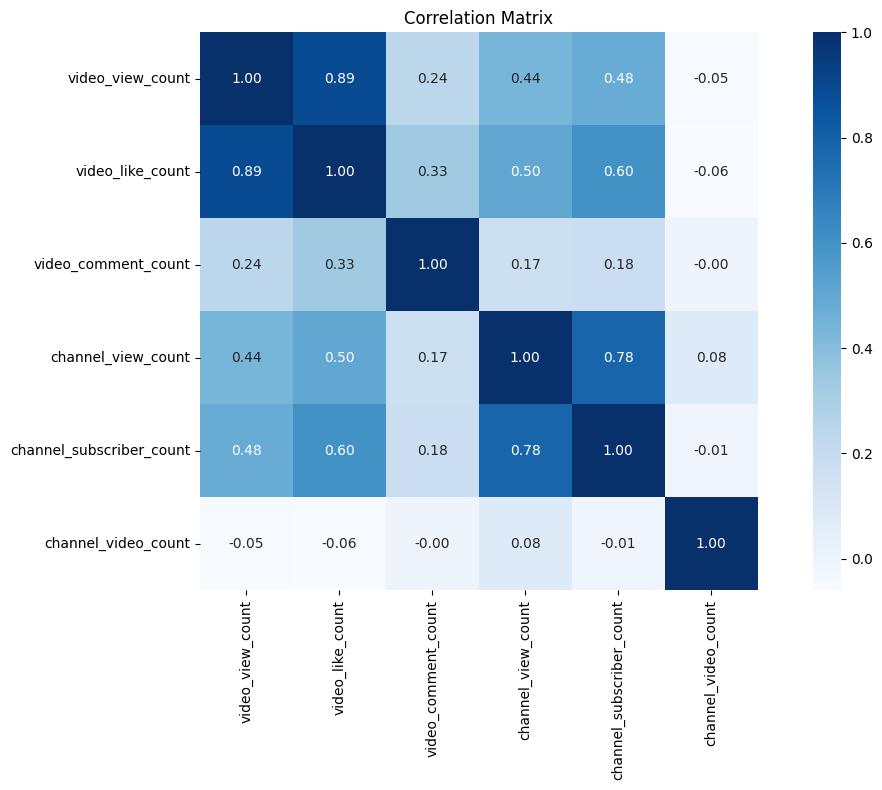

In [47]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### Time series

In [48]:
df['video_published_at'] = pd.to_datetime(df['video_published_at'], errors='coerce')
df['video_trending__date'] = pd.to_datetime(df['video_trending__date'], errors='coerce')

In [49]:
videos_per_day = df.groupby(df['video_published_at'].dt.date).size().reset_index(name='count')
videos_per_day['video_published_at'] = pd.to_datetime(videos_per_day['video_published_at'])

videos_per_day_rolling = videos_per_day['count'].rolling(window=7).mean()

fig = px.line(
    videos_per_day,
    x='video_published_at',
    y='count',
    markers=True,
    title='Number of videos uploaded per day',
    labels={'video_published_at': 'Date', 'count': 'Number of videos'}
)

fig.add_trace(
    go.Scatter(
        x=videos_per_day['video_published_at'],
        y=videos_per_day_rolling,
        mode='lines',
        name='Moving average (7 days)',
        line=dict(color='red'),
        opacity=1
    )
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of videos',
    template='plotly_white',
    showlegend=True
)

fig.show()

In [50]:
videos_per_category = df.groupby([df['video_category_id'], df['video_published_at'].dt.date]).size().reset_index(name='count')
videos_per_category['video_published_at'] = pd.to_datetime(videos_per_category['video_published_at'])

category_figures = []

for category in videos_per_category['video_category_id'].unique():
    category_data = videos_per_category[videos_per_category['video_category_id'] == category]
    category_rolling = category_data['count'].rolling(window=7).mean()

    fig = px.line(
        category_data,
        x='video_published_at',
        y='count',
        markers=True,
        title=f'Number of videos uploaded per day ({category})',
        labels={'video_published_at': 'Date', 'count': 'Number of videos'}
    )

    fig.add_trace(
        go.Scatter(
            x=category_data['video_published_at'],
            y=category_rolling,
            mode='lines',
            name='Moving average (7 days)',
            line=dict(color='red'),
            opacity=1
        )
    )

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Number of videos',
        template='plotly_white',
        showlegend=True
    )

    category_figures.append(fig)

for fig in category_figures:
    fig.show()

In [51]:
df['day_of_week'] = df['video_published_at'].dt.dayofweek
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['day_of_week'].map(day_names)

videos_per_dayofweek = df['day_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

fig = go.Figure(data=[go.Bar(
    x=videos_per_dayofweek.index,
    y=videos_per_dayofweek.values,
    marker_color='blue',
    opacity=0.6
)])

fig.update_layout(
    title='Number of videos uploaded per day of the week',
    xaxis_title='Day of the week',
    yaxis_title='Number of videos',
    template='plotly_white',
    xaxis=dict(tickmode='array', tickvals=videos_per_dayofweek.index),
    yaxis=dict(showgrid=True),
    showlegend=False
)

fig.show()

In [52]:
category_figures_day = []

for category in df['video_category_id'].unique():
    category_data = df[df['video_category_id'] == category]
    videos_per_dayofweek = category_data['day_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    fig = go.Figure(data=[go.Bar(
        x=videos_per_dayofweek.index,
        y=videos_per_dayofweek.values,
        marker_color='blue',
        opacity=0.6
    )])

    fig.update_layout(
        title=f'Number of videos uploaded per day of the week ({category})',
        xaxis_title='Day of the week',
        yaxis_title='Number of videos',
        template='plotly_white',
        xaxis=dict(tickmode='array', tickvals=videos_per_dayofweek.index),
        yaxis=dict(showgrid=True),
        showlegend=False
    )

    category_figures_day.append(fig)

for fig in category_figures_day:
    fig.show()

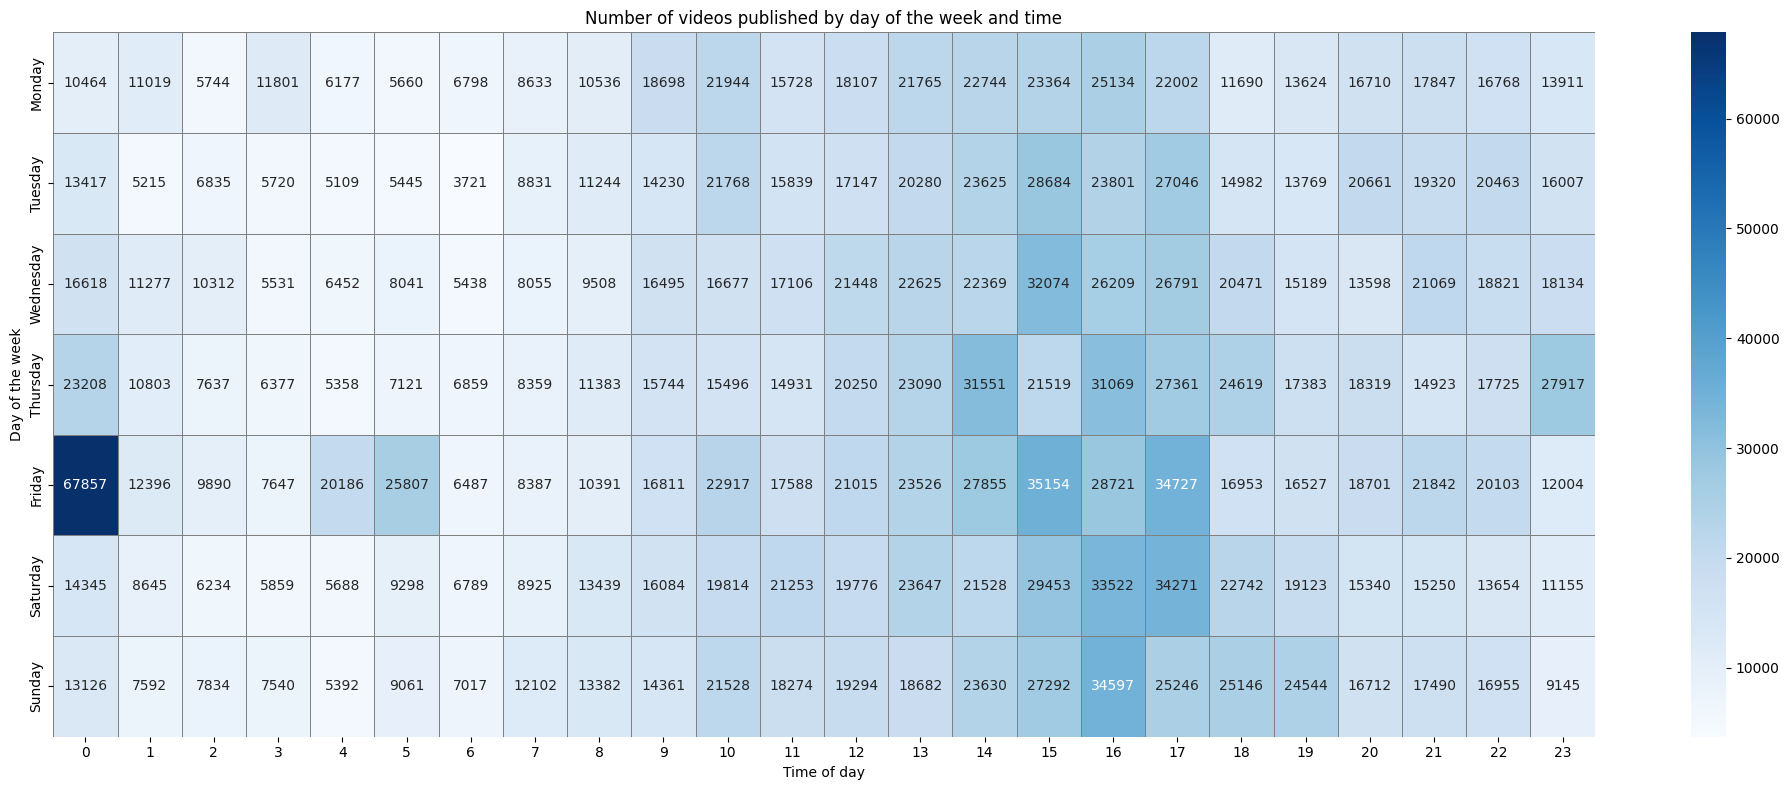

In [53]:
df['hour'] = df['video_published_at'].dt.hour

heatmap_data = df.pivot_table(index='day_of_week', columns='hour', values='video_published_at', aggfunc='count', fill_value=0)

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data.index = [day_names[int(d)] for d in heatmap_data.index]

plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap='Blues', linewidths=0.6, linecolor='gray', annot=True, fmt='d')
plt.title('Number of videos published by day of the week and time')
plt.xlabel('Time of day')
plt.ylabel('Day of the week')
plt.tight_layout()
plt.show()

In [54]:
df['month'] = df['video_published_at'].dt.month

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df['month_name'] = df['month'].map(month_names)

videos_per_month = df['month_name'].value_counts().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

fig = go.Figure(data=[go.Bar(
    x=videos_per_month.index,
    y=videos_per_month.values,
    marker_color='blue',  
    opacity=0.6           
)])

fig.update_layout(
    title='Number of videos uploaded per month',
    xaxis_title='Month',
    yaxis_title='Number of videos',
    template='plotly_white',
    xaxis=dict(tickmode='array', tickvals=videos_per_month.index),
    yaxis=dict(showgrid=True),
    showlegend=False
)

fig.show()

In [55]:
category_figures_month = []

for category in df['video_category_id'].unique():
    category_data = df[df['video_category_id'] == category]
    videos_per_month = category_data['month_name'].value_counts().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

    fig = go.Figure(data=[go.Bar(
        x=videos_per_month.index,
        y=videos_per_month.values,
        marker_color='blue',  
        opacity=0.6           
    )])

    fig.update_layout(
        title=f'Number of videos uploaded per month ({category})',
        xaxis_title='Month',
        yaxis_title='Number of videos',
        template='plotly_white',
        xaxis=dict(tickmode='array', tickvals=videos_per_month.index),
        yaxis=dict(showgrid=True),
        showlegend=False
    )

    category_figures_month.append(fig)

for fig in category_figures_month:
    fig.show()

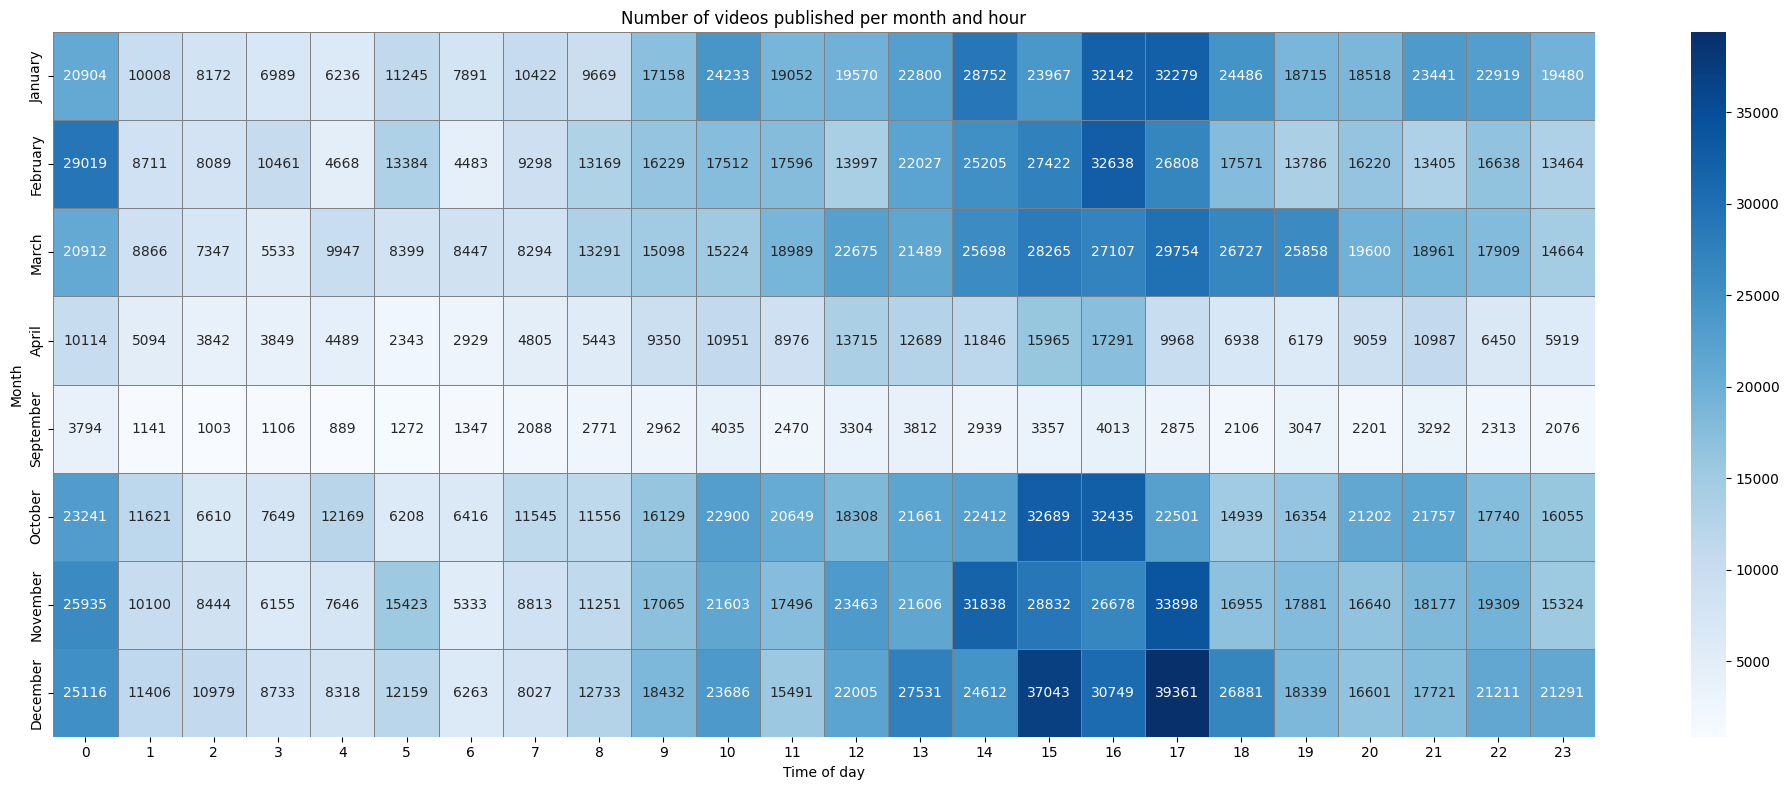

In [56]:
heatmap_data_month = df.pivot_table(index='month', columns='hour', values='video_published_at', aggfunc='count', fill_value=0)
heatmap_data_month.index = heatmap_data_month.index.map(month_names)

plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data_month, cmap='Blues', linewidths=0.6, linecolor='gray', annot=True, fmt='d')
plt.title('Number of videos published per month and hour')
plt.xlabel('Time of day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

**Note:** The dataframe contains data from September 2024 to the present, this explains why there is no record of some months.